# Predict Patient No Shows

**Purpose**<br>
In this presentation, we will examine a public dataset containing a subset of patient demographics, conditions, and attendance for their scheduled appointments. We will explore the the dataset, build a model, and evaluate its accuracy on a test set. This will launch us into a discussion on the strengths and limitations of the dataset, methods for model building, and the best practices for deploying a model to predict patient no-shows in the clinical environment. AI development is frequently compared to the wild west. In this presentation we seek to reinforce the critical need for clinical experts to collaborate with the development community to ensure algorithm development is moving in a direction that ultimately improves the quality and practice of radiological care. 


**Learning Objectives** <br>
- Walk meeting participants through a machine learning model. Understand how we evaluate these models.
- See the limitations in the dataset. How might clinican expertise improve this model?
- Provide an OSS base for participants to study and improve upon model performance at their facilities. 
- Understand the impetus behind use cases and why we need domain experts to guide the community through practical and ethical considerations.

**General Plan**

1. Lay out the Scenario
2. Pitch the algorithm
3. Walkthrough data analysis and model building
3. Try to break into the black box: Discovering algorithm strength and weaknesses
4. Discuss best practices for integrating a No-Show model in clincial environments

**Credit**<br>
Laura Brink, Deepak Kattilveettil, Mona Elkholy, Joni Hoppen

## Scenario

You are on the tech advisory committee for your facility that's tasked with finding worthwhile applications that could improve the quality and practice of our local facility(Insert a daily volume estimate of a small facility size). Vendor XYZ has approached your working group and shared one of their data sources & notebooks for building their algorithm. You are examining their work to evaluate whether to their solutions could help your facility.

## Algorithm Highlights

- Trainied and tested on over 110k patient appointments
- Recorded 92% accuracy on the test dataset
- Recorded 95% precision on the test dataset
- Mean square error on the test dataset of 0.0494
- Given 14 features on patient appointments in original data. Built the model with 25 after feature engineering. Accuracy likely to improve with even more features upfront.
- Identified correlations among the variables that could be sources for future research to predict patient no-shows or even more generally manage the health of local populations

## Walkthrough data analysis and model building

### Setup the environment

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn import ensemble
from sklearn import datasets
import seaborn as sns;
#may not need datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

In [2]:
#import csv data
df = pd.read_csv("KaggleV2-May-2016.csv")

This [public dataset](https://www.kaggle.com/joniarroba/noshowappointments) is hosted on Kaggle under [Creative Commons BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/)


>[Kaggle](https://www.kaggle.com) is an online community of data scientists and machine learners, owned by Google LLC. Kaggle allows users to find and publish data sets, explore and build models in a web-based data-science environment, work with other data scientists and machine learning engineers, and enter competitions to solve data science challenges.

[Kaggle Wikipedia Entry](https://en.wikipedia.org/wiki/Kaggle)

### Data Cleansing

In [3]:
# set an index object for manipulating tables later
index = df.index
# quick sample of the data
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [4]:
df.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show'],
      dtype='object')

In [5]:
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


We can make a few changes to make this data more readable to humans and machine.

- Let's eliminate the negation and title the column 'Attendance'. So the field, No-Show {No / Yes}, would translate to Attendance {1 / 0}

- Also, let's cleanup the spelling on the column headers. For example hypertension and handicap are misspelled.

- Convert Gender {M / F} to Gender {1 / 0} for easier application in our models


In [6]:
#The only field with Yes/No is the No-Show column. Let's change this from 'no show' to 'attendance'. Thus patients 
#marked with Yes for no-show would be a 0 for attendance. 
df = df.replace('No', 1)
df = df.replace('Yes',0)

#Change Male to 1 and female to 0
df = df.replace('M',1)
df = df.replace('F', 0)

df = df.rename(columns={"PatientId": "PatientId", "AppointmentID": "AppointmentID", "Gender":"Gender", 
                   "ScheduledDay":"ScheduledDay","AppointmentDay":"AppointmentDay", "Age":"Age",
                   "Neighbourhood":"Neighborhood", "Scholarship":"Scholarship", "Hipertension":"Hypertension", 
                   "Diabetes":"Diabetes","Alcoholism":"Alcoholism","Handcap":"Handicap", "SMS_received":"SMS_Reminders",
                  "No-show":"Attendance"})

In [7]:
print("There are", df.shape[0], "records and", df.shape[1], "features \n")
print(df.describe())

There are 110527 records and 14 features 

          PatientId  AppointmentID         Gender            Age  \
count  1.105270e+05   1.105270e+05  110527.000000  110527.000000   
mean   1.474963e+14   5.675305e+06       0.350023      37.088874   
std    2.560949e+14   7.129575e+04       0.476979      23.110205   
min    3.921784e+04   5.030230e+06       0.000000      -1.000000   
25%    4.172614e+12   5.640286e+06       0.000000      18.000000   
50%    3.173184e+13   5.680573e+06       0.000000      37.000000   
75%    9.439172e+13   5.725524e+06       1.000000      55.000000   
max    9.999816e+14   5.790484e+06       1.000000     115.000000   

         Scholarship   Hypertension       Diabetes     Alcoholism  \
count  110527.000000  110527.000000  110527.000000  110527.000000   
mean        0.098266       0.197246       0.071865       0.030400   
std         0.297675       0.397921       0.258265       0.171686   
min         0.000000       0.000000       0.000000       0.000000   

On first glance, we see that about 80% of patients attend their appointment. Is there anything about the 20% who do not make their appointment that would allow us to predict a no-show?

### Identify outliers

Most fields are binaries which make it a bit more difficult to sift out outliers in our dataset. Age immediately grabs attention as there are some patients labelled -1 and 115. Let's take a closer look. 

Text(0.5, 1.0, 'Ages represented in the data')

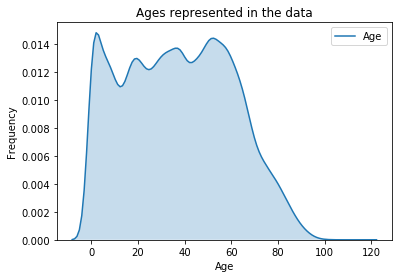

In [8]:
sns.kdeplot(df.Age, shade = True)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Ages represented in the data')

Remove ages -1 as well as those >= 100 from the data

In [9]:
df = df[(df.Age >=0) & (df.Age < 100)]

Text(0.5, 1.0, 'Attendance by Age')

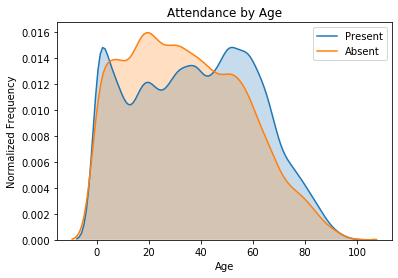

In [10]:
# Attendance distribution by Age
sns.kdeplot(df.loc[df['Attendance'] == 1, 'Age'], label = 'Present', shade = True)
sns.kdeplot(df.loc[df['Attendance'] == 0, 'Age'], label = 'Absent', shade = True)
plt.xlabel('Age')
plt.ylabel('Normalized Frequency')
plt.title('Attendance by Age')

- Young people are more likely to miss their appointment that attend, particularly between the ages of 15-50.
- Older patients are more likely to attend their appointments.

### Date Analysis

Let's take a look at what dates we're examining here. We have both scheduled date and appointment date to dig into. Unfortunately the appointment date only provides the day/month/year of the visit while scheduled date gives the time of day. Some features we can extract from this data:

- WaitingDays : difference between scheduled date and appointment date
- AppointmentDayofWeek : Mon / Tues / Wed / Thurs / Fri / Sat / Sun
- ScheduledDayofWeek : Mon / Tues / Wed / Thurs / Fri / Sat / Sun
- AppointmentTimeOfDay: AM / PM



In [11]:
print(df.AppointmentDay.head(),
df.ScheduledDay.head())

0    2016-04-29T00:00:00Z
1    2016-04-29T00:00:00Z
2    2016-04-29T00:00:00Z
3    2016-04-29T00:00:00Z
4    2016-04-29T00:00:00Z
Name: AppointmentDay, dtype: object 0    2016-04-29T18:38:08Z
1    2016-04-29T16:08:27Z
2    2016-04-29T16:19:04Z
3    2016-04-29T17:29:31Z
4    2016-04-29T16:07:23Z
Name: ScheduledDay, dtype: object


In [12]:
#Pandas offers nifty support for analyzing datetimes. Let's convert these series into pandas 
#datatime objects with pd.to_datetime
df.ScheduledDay = pd.to_datetime(df.ScheduledDay)
df.AppointmentDay = pd.to_datetime(df.AppointmentDay)
print("Appointments occur between",df.AppointmentDay.min(),"and", df.AppointmentDay.max())

Appointments occur between 2016-04-29 00:00:00+00:00 and 2016-06-08 00:00:00+00:00


- This is **roughly five weeks** of appointments. This is likely another major limitation of building a model from this data.
- Notice that hour:min:sec data is not recorded for the appointment though this data is captured for the scheduling time

Text(0.5, 1.0, 'Mean Attendance by appointment day of week')

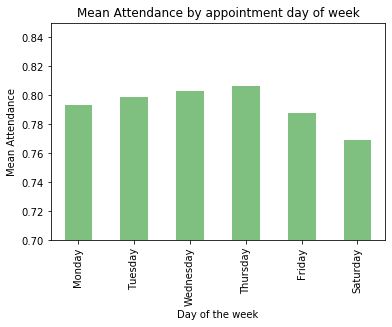

In [13]:
##Create a new column that tracks the appointment day of week (Mon, Tuesday, Wednesday, Thurs, Fri, Sat, Sun)
## Add this new column to our dataframe
df['AppointmentDayOfWeek'] = df.AppointmentDay.map(lambda day: day.day_name())

SMSbyAppointment = df['Attendance'].groupby(df['AppointmentDayOfWeek'],sort=False)

SMSbyAppointment.mean().reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']).plot.bar(color='green', alpha=0.5)
plt.ylabel('Mean Attendance')
plt.xlabel('Day of the week')
plt.ylim((0.7, 0.85))
plt.title('Mean Attendance by appointment day of week')

- Drop in attendance on Friday and Saturday
- Highest attendance on Wednesday and Thursday appointments 

In [14]:
#creates dummy variables to account for AppointmentdAyOfWeek Categorical data
dummy = pd.get_dummies(df.AppointmentDayOfWeek)
df= pd.concat([df,dummy], axis =1)

Text(0.5, 1.0, 'Rate of SMS Reminders Sent By Schedule Date')

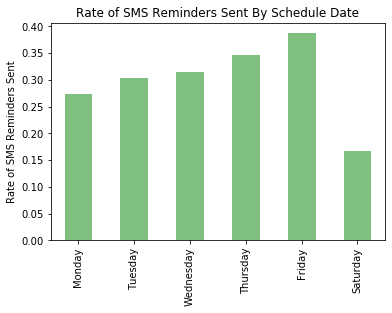

In [15]:
##Create a new column that tracks the scheduled day of week
df['ScheduledDayOfWeek'] = df.ScheduledDay.map(lambda day: day.day_name())

SMSbySchedule = df['SMS_Reminders'].groupby(df['ScheduledDayOfWeek'])

SMSbySchedule.mean().reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']).plot.bar(color='green',alpha=0.5)
plt.ylabel('Rate of SMS Reminders Sent')
plt.xlabel('')
plt.title('Rate of SMS Reminders Sent By Schedule Date')

- Sharp drop in text rates for appointments scheduled on saturday.
- Other than saturday, as the week progresses, so does the rate of texts sent from the facility

More SMS were sent later in the week, though the facilities sent out fewer texts when the appointment was scheduled on a Saturday. How many instances are there of a patient scheduleding their appointment on a saturday?

In [16]:
df.ScheduledDayOfWeek.apply(lambda x: str(x))
print("There are",df[df.ScheduledDayOfWeek=='Saturday'].shape[0],"instances of an appointment scheduled on Saturday")

There are 24 instances of an appointment scheduled on Saturday


Let's drop these as they don't seem to be representative of the relationship for SMS_reminders on attendance.

In [17]:
df = df[df.ScheduledDayOfWeek!='Saturday']

In [18]:
def convertdaytonumber(day):
    if day == 'Monday':
        return 1
    if day == 'Tuesday':
        return 2
    if day == 'Wednesday':
        return 3
    if day == 'Thursday':
        return 4
    if day == 'Friday':
        return 5
    if day == 'Saturday':
        return 6
    if day == 'Sunday':
        return 7

##Create a new column that tracks the scheduled day of week
df['ScheduledDayOfWeekNumeric'] = df.ScheduledDayOfWeek.map(lambda day: convertdaytonumber(day))

In [19]:
##This will calculate the days in between appointment and scheduling date. Since the appointment column doens't have a
## time of appointment, we're rounding here. Basically removing the time format from the ScheduledDate section.
WaitFromScheduledDate = (df.AppointmentDay.map(lambda x: x.date()) - df.ScheduledDay.map(lambda x: x.date()))

df['WaitFromScheduledDate'] = WaitFromScheduledDate.map(lambda x: x.days)

Text(0, 0.5, 'Instances')

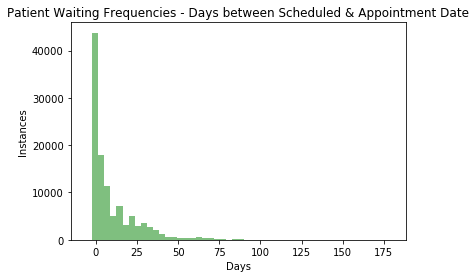

In [20]:
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
ax1.hist(df.WaitFromScheduledDate, bins = 50, color ='green', alpha = 0.5)
ax1.set_title('Patient Waiting Frequencies - Days between Scheduled & Appointment Date')
ax1.set_xlabel('Days')
ax1.set_ylabel('Instances')



In [21]:
df[df.WaitFromScheduledDate < 0].shape
df = df[df.WaitFromScheduledDate >= 0]
#Eliminate all records where wait time is less than 0 days

Negative difference between scheduled date and appointment day makes no sense. Drop these values.

Text(0.5, 1.0, 'Attendance by Waiting')

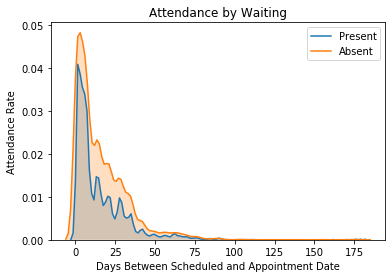

In [22]:
# Attemdance by waiting day
sns.kdeplot(df.loc[df['Attendance'] == 1, 'WaitFromScheduledDate'], label = 'Present', shade = True)
sns.kdeplot(df.loc[df['Attendance'] == 0, 'WaitFromScheduledDate'], label = 'Absent', shade = True)
plt.xlabel('Days Between Scheduled and Appointment Date')
plt.ylabel('Attendance Rate')
plt.title('Attendance by Waiting')


Text(0.5, 1.0, 'Attendance by Waiting')

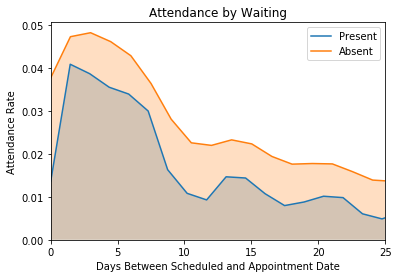

In [23]:
# Attemdance by waiting day
sns.kdeplot(df.loc[df['Attendance'] == 1, 'WaitFromScheduledDate'], label = 'Present', shade = True)
sns.kdeplot(df.loc[df['Attendance'] == 0, 'WaitFromScheduledDate'], label = 'Absent', shade = True)
plt.xlabel('Days Between Scheduled and Appointment Date')
plt.xlim([0,25])
plt.ylabel('Attendance Rate')
plt.title('Attendance by Waiting')

Intuitively, would assume that the greater the wait time between the scheduled and appointment date, the more likely the the patient would miss their appointment. But it seems that of the appointments that are missed, most of them are from patients scheduling less than 50 days out. Noteably there's a large portion of the no-shows that come from patients scheduling their appointments less than 10 days out. 

SMS_Reminders
0    0.833009
1    0.724208
Name: Attendance, dtype: float64

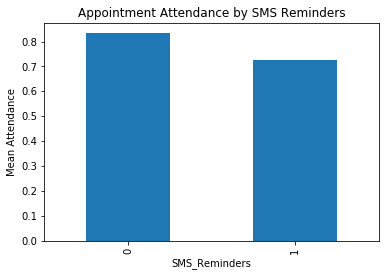

In [24]:
grouping = df['Attendance'].groupby(df['SMS_Reminders'])
grouping.mean().plot.bar()

plt.ylabel('Mean Attendance')
plt.title('Appointment Attendance by SMS Reminders')
grouping.mean()

Whoa. Those patients who did not receive an SMS reminders atteded their appointment 80% of the time compared to about 70% attendance among patients who received an SMS. This is a bit counter-intuitive. What's happening here? 


Perhaps the facility identifies patients at high risk of missing their appointment and sends SMS to those individuals? Perhaps its wealthier populations who can sign up for automated texting, who are also less likely to show up to a state-funded clinic appointment? Let's continue to dig into SMS relationships.

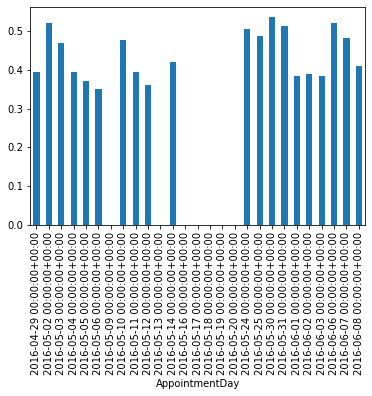

In [25]:
#How frequently are text messages sent from the facility?
grouping = df['SMS_Reminders'].groupby(df['AppointmentDay'])
grouping.mean().plot.bar()

There's over a week of time where appointments were taken, but no SMS reminders were sent! Was the system down? How many records is this?

In [26]:
#Confirming the dates when no texts were distributed
print(df[(df.AppointmentDay>="2016-05-15") & (df.AppointmentDay <= "2016-05-23")].SMS_Reminders.mean())

print("There are", df[(df.AppointmentDay>="2016-05-15") & (df.AppointmentDay <= "2016-05-23")].shape[0], "records during this window",
     "or", "{:.1%}".format(df[(df.AppointmentDay>="2016-05-15") & (df.AppointmentDay <= "2016-05-23")].shape[0]/df.shape[0]), "percent of the data")

0.0
There are 21446 records during this window or 19.4% percent of the data


It's costly to discard 19% of your data for model building/testing- but we should do so. For whatever reason texts were not distributed for a whole week on an already limited dataset. So it's going to be very tricky to make any determinations about how texting affects the attendance rate without accounting for this week.

Ran the models with and without these data. When removing this week worth of data, the accuracy improved by 2%. Models seems to have a much harder time to predict guage the attendance relationship when trying to account for this week. Let's remove this week of data.

In [27]:
df = df[(df.AppointmentDay<"2016-05-15") | (df.AppointmentDay > "2016-05-23")]

SMS_Reminders
0    0.853148
1    0.724208
Name: Attendance, dtype: float64

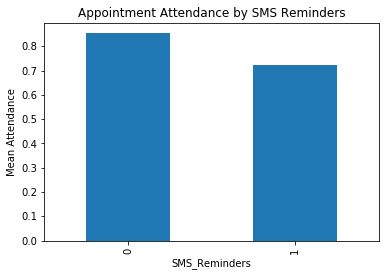

In [28]:
#Check the attendance to SMS relationship now.
grouping = df['Attendance'].groupby(df['SMS_Reminders'])
grouping.mean().plot.bar()

plt.ylabel('Mean Attendance')
plt.title('Appointment Attendance by SMS Reminders')
grouping.mean()

It's not even more glaring! People who did not receive an SMS were more likely to show up to their appointment. Waht else could be going on?

WaitFromScheduledDate
0    0.953069
1    0.790396
2    0.756226
3    0.763569
4    0.771698
5    0.742049
6    0.758652
7    0.729199
8    0.716075
9    0.728827
Name: Attendance, dtype: float64


Text(0.5, 1.0, 'Appointment Attendance by Days Awaiting Appointment')

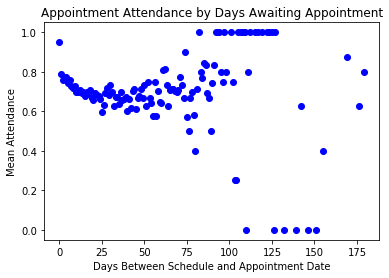

In [29]:
grouping = df['Attendance'].groupby(df['WaitFromScheduledDate'])
print(grouping.mean().head(10))
plt.plot(grouping.mean(), 'bo')
plt.ylabel('Mean Attendance')
plt.xlabel('Days Between Schedule and Appointment Date')
plt.title('Appointment Attendance by Days Awaiting Appointment')

People who made appointments THAT day were very likely to show up (~95%). Maybe these were patients who didn't receive an SMS? Let's check that grouping.

Additionally, there's a lot of variance in the relationship between attendance and Wait from scheduled date when observing patients who scheduled appointments beyond 125 days out. Let's cut these. Recommend that the facility follow up less than one or two months out to confirm the appointment. 

In [30]:
print("There are",df[df.WaitFromScheduledDate >125].shape[0], "instances in the data of patients who scheduled their appointment over 125 days out.")
df = df[df.WaitFromScheduledDate <=125]
#Eliminate the records of patients waiting more than 125 days

There are 58 instances in the data of patients who scheduled their appointment over 125 days out.


WaitFromScheduledDate
0    0.000000
1    0.000000
2    0.000000
3    0.416283
4    0.720283
5    0.806439
6    0.800716
7    0.736434
8    0.751566
9    0.774670
Name: SMS_Reminders, dtype: float64


Text(0.5, 1.0, 'SMS Reminder Rate by Days Awaiting Appointment')

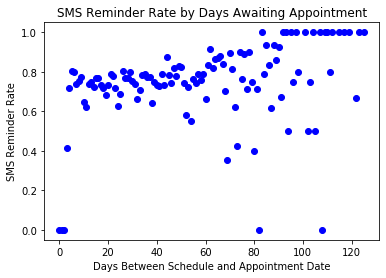

In [31]:
grouping = df['SMS_Reminders'].groupby(df['WaitFromScheduledDate'])
print(grouping.mean().head(10))
plt.plot(grouping.mean(), 'bo')
plt.ylabel('SMS Reminder Rate')
plt.xlabel('Days Between Schedule and Appointment Date')
plt.title('SMS Reminder Rate by Days Awaiting Appointment')

So patients who waited less than three days, did not receive SMS reminders for their appointment. 

In [32]:
print("Roughly", "{:.1%}".format(df[df.WaitFromScheduledDate == 0].shape[0]/df.shape[0]), "percent of the records are of patients who scheduled their appointment on that very day") 

Roughly 35.2% percent of the records are of patients who scheduled their appointment on that very day


Of those patients, 95% attended their appointment - so this is significantly skewing our data. Over one third of the data accounts for patients who scheduled that day (so no SMS) and nearly always attended their appointment. These are individuals we do not need a model to predict. Let's assume that if a patient schedules their appointment for that day, that they will show up. So we can remove records from patients scheduling that day.


In [33]:
df= df[df.WaitFromScheduledDate != 0]

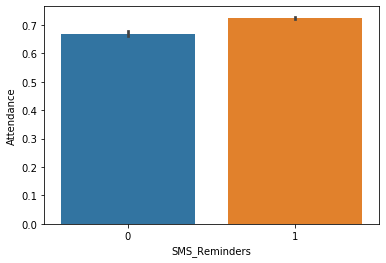

In [34]:
sns.barplot(x='SMS_Reminders',y='Attendance', data=df[df.WaitFromScheduledDate >2], orient = 'v')
#USing Wait time >2 because there are no text messages sent when the appointment is within 
#three days of the schedule date


In [35]:
##Can turn the datetime object into a new feature representing the hour of the day (24:00 clock)
def calculateHour(timestamp):
    timestamp = str(timestamp)
    hour = int(timestamp[11:13])
    minute = int(timestamp[14:16])
    second = int(timestamp[17:19])
    return round(hour + minute/60 + second/3600)

df['ScheduledHourOfDay'] = df.ScheduledDay.apply(calculateHour)

This will return the hour of the day closest to when the apointment was scheduled. Perhaps there's a time of day when setting follow-up reminders in place are missed. 

We're not applying this to AppointmentDay because that level of specificity wasn't tracked across the appointments in the original data (only year - month - day)

Text(0.5, 1.0, 'Appointment Attendance by Scheduled Time of Day')

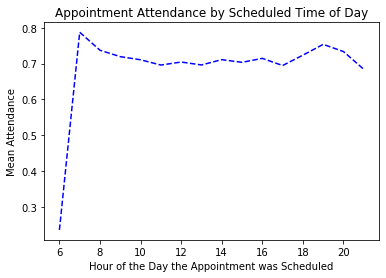

In [36]:
grouping = df['Attendance'].groupby(df['ScheduledHourOfDay'])
plt.plot(grouping.mean(), 'b--')
plt.ylabel('Mean Attendance')
plt.xlabel('Hour of the Day the Appointment was Scheduled')
plt.title('Appointment Attendance by Scheduled Time of Day')

Appointments scheduled earlier (at least after 6am) see a higher appointment attendance rate. 

Text(0.5, 1.0, 'Appointment Attendance by Scheduled Time of Day')

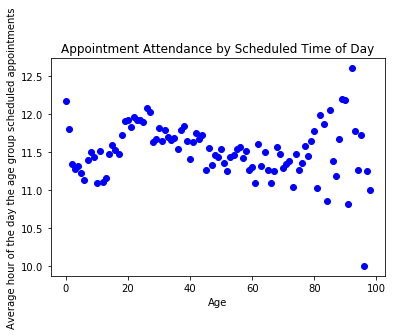

In [37]:
grouping = df['ScheduledHourOfDay'].groupby(df['Age'])
plt.plot(grouping.mean(), 'bo')
plt.ylabel('Average hour of the day the age group scheduled appointments')
plt.xlabel('Age')
plt.title('Appointment Attendance by Scheduled Time of Day')

Text(0.5, 1.0, 'Time of Day Scheduling the Appointment on Days Before Appointment')

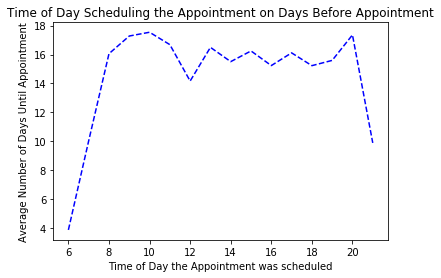

In [38]:
grouping = df['WaitFromScheduledDate'].groupby(df['ScheduledHourOfDay'])
plt.plot(grouping.mean(), 'b--')
plt.ylabel('Average Number of Days Until Appointment')
plt.xlabel('Time of Day the Appointment was scheduled')
plt.title('Time of Day Scheduling the Appointment on Days Before Appointment')


Few insights from this new variable

- Patients are less likely to attend appointments when scheduled later in the day
- Older patients tend to handle the scheduling process earlier in the day
- Appointments scheduled later in the day are typically closer to the actual date
- If we want to improve the model accuracy we could remove patients who scheduled their appointments before 7am or after 8pm as these seem to be potential outliers -- could be emergency situations.

**Link patients by patient ID**

In [39]:
print("There are",len(df.PatientId.unique()),"unique patients in the data")
print("There are",len(df.AppointmentID.unique()),"unique appointment Ids in the data")
print("{:.1%}".format(df.PatientId.unique().shape[0]/df.shape[0]), "of the data are unique patients")
print("{:.1%}".format(1-(df.PatientId.unique().shape[0]/df.shape[0]))," of the data are returning patients")



There are 39049 unique patients in the data
There are 57702 unique appointment Ids in the data
67.7% of the data are unique patients
32.3%  of the data are returning patients


Since we note a significant chunk of the data are returning patients, let's create a new variable that tracks how may appointments the patient has scheduled. The appointment frequency could be an important variable to building this model.

In [40]:
ScheduledAppointmentFrequencies = pd.value_counts(df.PatientId.values, sort=True)
print("The mean number of scheduled appointments is ", ScheduledAppointmentFrequencies.mean())
ScheduledAppointmentFrequencies.describe()


The mean number of scheduled appointments is  1.477681886860099


count    39049.000000
mean         1.477682
std          1.036627
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         25.000000
dtype: float64

Text(0, 0.5, 'Count of patients')

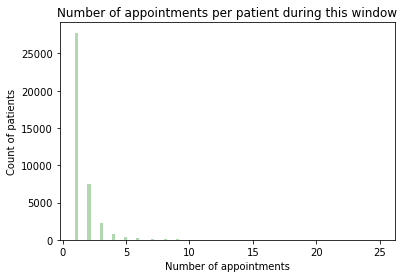

In [41]:
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
ax1.hist(ScheduledAppointmentFrequencies, bins = 100, color ='green', alpha = 0.3)
ax1.set_title('Number of appointments per patient during this window')
ax1.set_xlabel('Number of appointments')
ax1.set_ylabel('Count of patients')

We can see from this data that not many patients have scheduled more than five appointments for this month long period. We should be able to say that patients scheduling ten or more times are outliers and should be treated differently by this model. These patients are basically seen once every two-three days- should be fair to assume that you'd develop more of a relationship with the patient. With that sort of relationship you might be able to know the patient's tendencies for attendance better than an algorithm from these 14 metrics. 

In [42]:
print("There are",ScheduledAppointmentFrequencies[ScheduledAppointmentFrequencies>=10].shape[0],"patients with 10 or more visits this month")

There are 64 patients with 10 or more visits this month


In [43]:
SIndex=ScheduledAppointmentFrequencies[ScheduledAppointmentFrequencies>=10].index


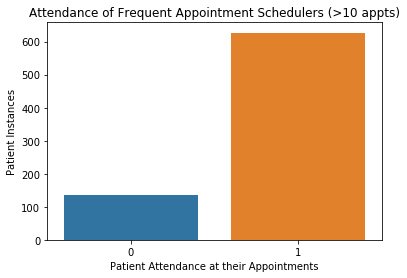

Patients who have 10 or more appointments in this window attend their appointments 82.3% of the time
Patients who have less than 10 appointments in this window attend their appointments 71.9% of the time


In [44]:
groups = df[df.PatientId.isin(list(SIndex))].groupby(['Attendance'])
gps = groups.size()
ax = sns.barplot(x=gps.index.tolist(), y=gps.values)
plt.ylabel('Patient Instances')
plt.xlabel('Patient Attendance at their Appointments')
plt.title('Attendance of Frequent Appointment Schedulers (>10 appts)')
plt.show()
print("Patients who have 10 or more appointments in this window attend their appointments", "{:.1%}".format(df[df.PatientId.isin(list(SIndex))].Attendance.mean()), "of the time")
print("Patients who have less than 10 appointments in this window attend their appointments", "{:.1%}".format(df[-df.PatientId.isin(list(SIndex))].Attendance.mean()), "of the time")

Frequent schedulers attend their appointments more often than patients who have scheduled less than 10 appointments to their clinic.

Let's add another feature to this data that points out just how many appointments the patient scheduled during this window. 

In [45]:
frequency = pd.value_counts(df.PatientId.values, sort=True)
apptfreqdict={}

for entry in frequency.index:
    apptfreqdict[entry] = frequency[entry]

In [46]:
df['ApptFreq'] = pd.Series(df.PatientId, index=df.index)
df['ApptFreq']= df['ApptFreq'].map(apptfreqdict)
#Apptfreq is the normalized frequency (for model building purposes) of appointments the patient scheduled during this window. 

Just as we've added a feature indicating how frequently someone schedules appointments. We should add a feature that indicates how many appointments this patient has missed. The best indicator for future behavior is past behavior.

In [47]:
x= df[df.Attendance == 0]
FreqOfNoShow={}
for x in df.PatientId.unique():
    FreqOfNoShow[x]=0
    #df['word'].value_counts()
    
absencelist = df[df.Attendance == 0].loc[:,'PatientId']
AbsenceFreq = pd.value_counts(absencelist.values, sort=True)
AbsenceFreq
#AbsenceFreq will be a normalized value that represents how often a patient misses their appointment.
FreqOfNoShow={}
for entry in AbsenceFreq.index:
    FreqOfNoShow[entry] = AbsenceFreq[entry]
    
df['AbsenceFreq'] = pd.Series(df.PatientId, index=df.index)
df['AbsenceFreq']= df['AbsenceFreq'].map(FreqOfNoShow)
df['AbsenceFreq']= df['AbsenceFreq'].fillna(0)

#Now we have variables for how frequently a patient is seen in a 
#window of time and how frequently they've missed appointments


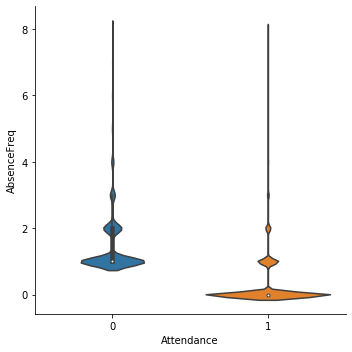

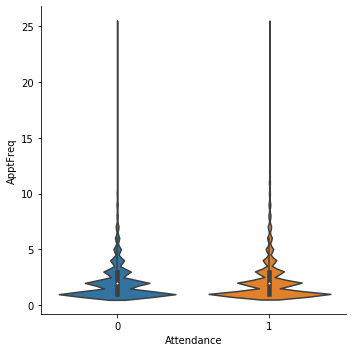

In [48]:
fig1=sns.catplot(x="Attendance", y="AbsenceFreq", kind='violin',  data=df)
fig2= sns.catplot(x="Attendance", y="ApptFreq", kind='violin',  data=df)

**Neighborhood Insights**

Let's extract all the unique neighborhoods. Classify each neighborhood by its geographic location. Some places may be more accessible to medical care than others.

Went on Google maps and labeled each of the 81 neighborhoods into six regions by their geography and proximity to local clinics. You can see the map of all neighborhoods (blue) and clinics (red) here: <Link>

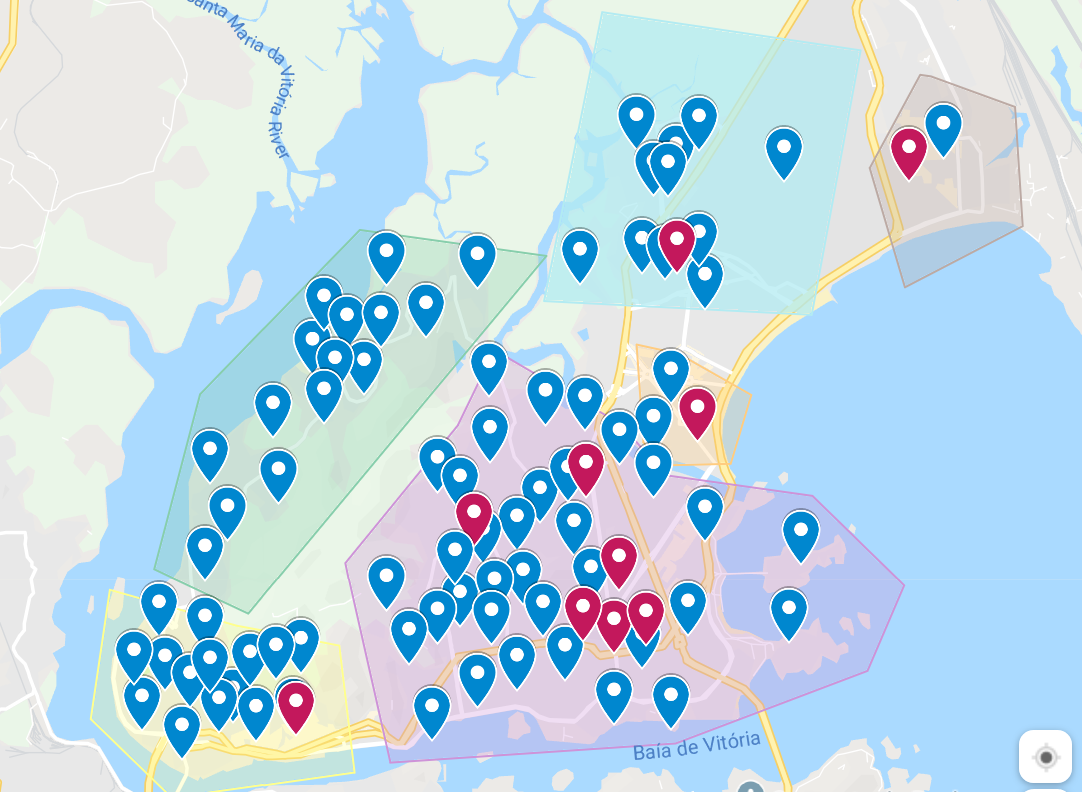

In [49]:
from IPython.display import Image
Image(filename='NeighborhoodGraphic.png') 
#Green = Region A
#Yellow = Region B
#Red = Region C
#Orange = Region D
#Blue = Region E
#Gray = Region F


In [50]:
#This is a local csv copy of all the neighborhoods and their regional attribute as shown in the map above
AllNeighborhoods = pd.read_csv("AllNeighborhoods.csv", usecols=["Neighborhood", "Grouping"],index_col= 'Neighborhood')

Could not place ILHAS OCEÂNICAS DE TRINDADE or PARQUE INDUSTRIAL on the map. Check how many datapoints come from these neighborhoods. Might drop them.

In [51]:
df[((df.Neighborhood == "ILHAS OCEÂNICAS DE TRINDADE") | (df.Neighborhood == "PARQUE INDUSTRIAL"))].shape

(2, 27)

Only two records, so let's drop these. 

In [52]:
df = df[-((df.Neighborhood == "ILHAS OCEÂNICAS DE TRINDADE") | (df.Neighborhood == "PARQUE INDUSTRIAL"))]

Okay so now I want to assign the new variable "Grouping" to the working dataframe, df. 

In [53]:
#First convert the neighborhoods to dictionary
AllNeighborhoods= AllNeighborhoods.to_dict()
AllNeighborhoods= AllNeighborhoods['Grouping']
df['NeighborhoodGrouping'] = df.Neighborhood
df.NeighborhoodGrouping = df.NeighborhoodGrouping.map(AllNeighborhoods)

/home/jordan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/jordan/miniconda3/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Now let's create the six dummy variables so that we can use these data in our models. 

In [54]:
dummy = pd.get_dummies(df.NeighborhoodGrouping)
df= pd.concat([df,dummy], axis =1)

Text(0.5, 1.0, 'Mean Attendance by Neighborhood Region')

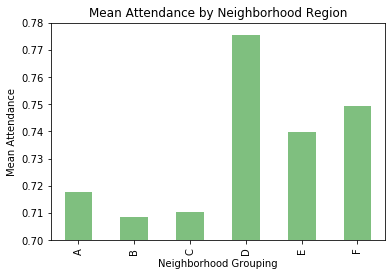

In [146]:
NeighboorhoodAttendance = df['Attendance'].groupby(df['NeighborhoodGrouping'],sort=False)

NeighboorhoodAttendance.mean().reindex(['A','B','C','D','E','F']).plot.bar(color='green', alpha=0.5)
plt.ylabel('Mean Attendance')
plt.xlabel('Neighborhood Grouping')
plt.ylim((0.7, 0.78))
plt.title('Mean Attendance by Neighborhood Region')

Text(0.5, 1.0, 'Alcoholism by Neighborhood Region')

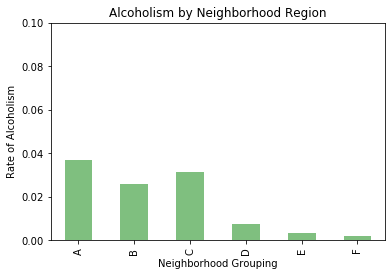

In [151]:
NeighboorhoodG = df['Alcoholism'].groupby(df['NeighborhoodGrouping'],sort=False)

NeighboorhoodG.mean().reindex(['A','B','C','D','E','F']).plot.bar(color='green', alpha=0.5)
plt.ylabel('Prevalence of Alcoholism')
plt.xlabel('Neighborhood Grouping')
plt.ylim((0,0.1))
plt.title('Alcoholism by Neighborhood Region')

Text(0.5, 1.0, 'Diabetes by Neighborhood Region')

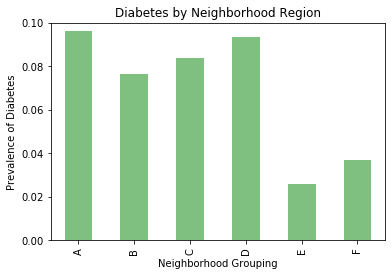

In [153]:
NeighboorhoodG = df['Diabetes'].groupby(df['NeighborhoodGrouping'],sort=False)

NeighboorhoodG.mean().`reindex(['A','B','C','D','E','F']).plot.bar(color='green', alpha=0.5)
plt.ylabel('Prevalence of Diabetes')
plt.xlabel('Neighborhood Grouping')
plt.ylim((0,0.1))
plt.title('Diabetes by Neighborhood Region')

Text(0.5, 1.0, 'Scholarship by Neighborhood Region')

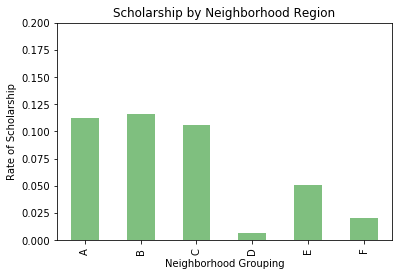

In [158]:
NeighboorhoodG = df['Scholarship'].groupby(df['NeighborhoodGrouping'],sort=False)

NeighboorhoodG.mean().reindex(['A','B','C','D','E','F']).plot.bar(color='green', alpha=0.5)
plt.ylabel('Rate of Scholarship')
plt.xlabel('Neighborhood Grouping')
plt.ylim((0,0.2))
plt.title('Scholarship by Neighborhood Region')

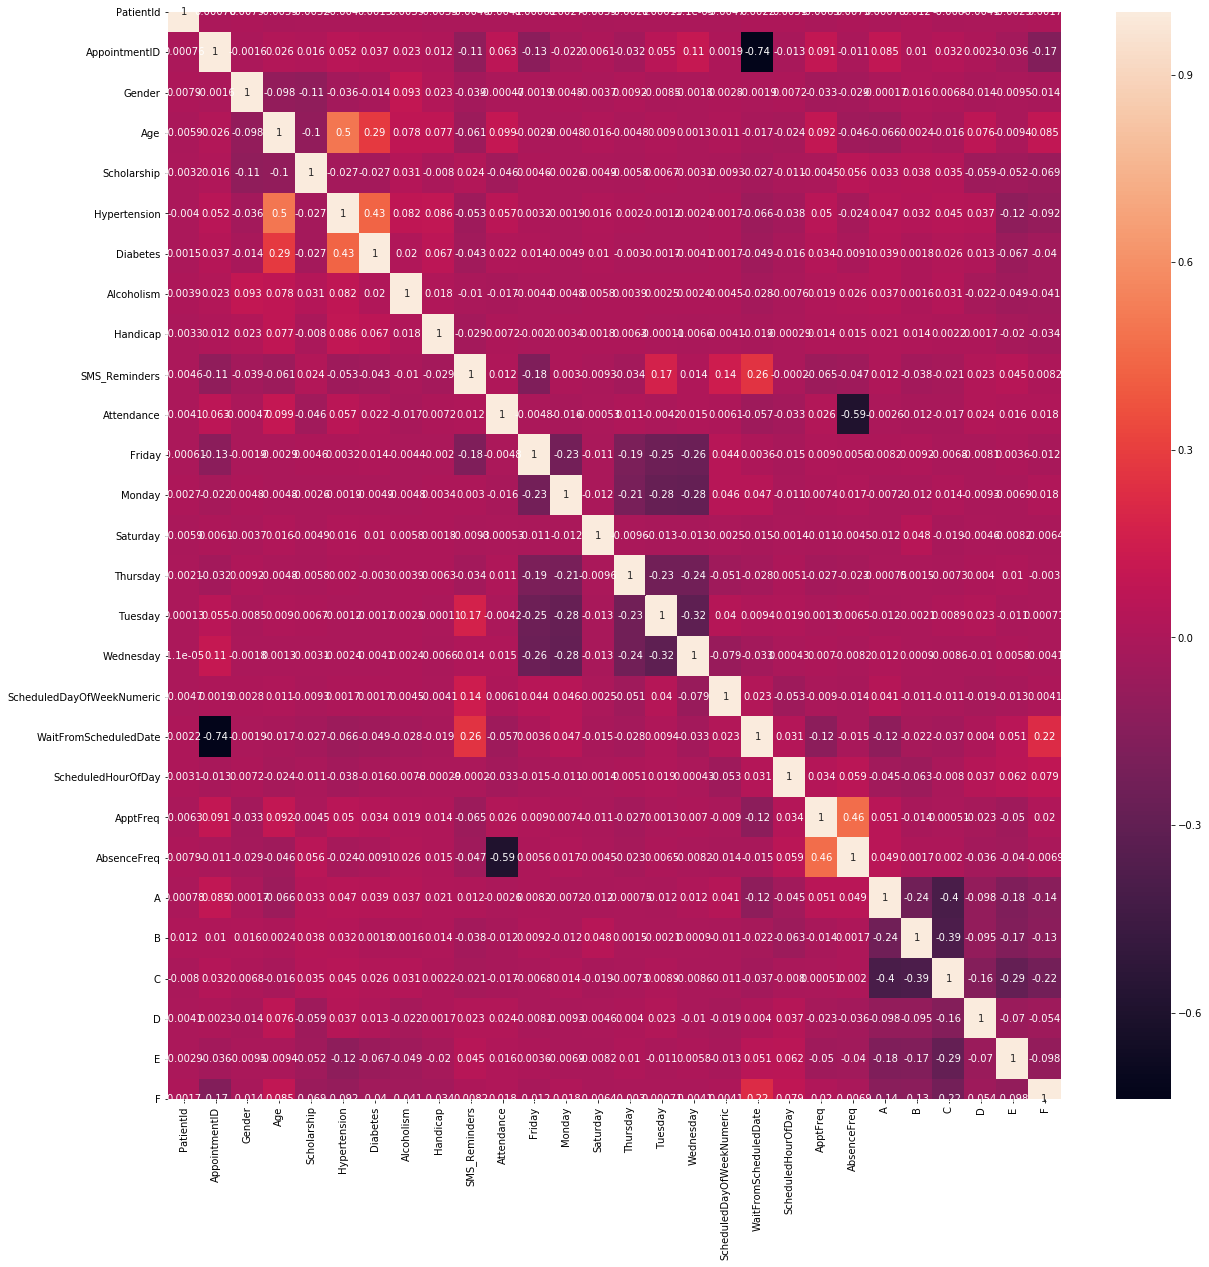

In [55]:
plt.figure(figsize = (20,20))        # Size of the figure
sns.heatmap(df.corr(),annot = True)
plt.show()

Potential Relationships to investigate. This work could be done to fine-tune our models and avoid any multicollinearity issues. Though we could also dive into these relationships to propose policies that might improve patient attendance and population health.
Age : Diabetes (+) <br>
Age : Hypertension (+)<br>
Diabetes : Hypertension (+)<br>
SMS Reminders : Tuesday Appt (+)<br>
SMS Reminders : Friday Appt (-)<br>
SMS Reminders : DAy of the Week the Appointment was scheduled (+)<br>
SMS Reminders : Wait Between Scheduled and Appointment Date (+)<br>
Wait Between Scheduled and Appointment Date : Region F (+)<br>
Wait Between Scheduled and Appointment Date : Region A (-)


## Model Building

In [56]:

# Select feature variables to X. Drop strings and non-numeric objects
X = df.drop(['Attendance', 'PatientId', 'AppointmentID', 'ScheduledDay', 'AppointmentDay', 'AppointmentDayOfWeek','ScheduledDayOfWeek', 'Neighborhood','NeighborhoodGrouping'] ,axis=1)
# Select response variable to y
y = df['Attendance']

In [57]:
#Split data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=100)
X_tr = X_train
y_tr = y_train

### Logistic Regression

First try a naive model. Let's see how well a model performs that predicts everyone attends their appointment (which may be the working assumption of the facility now).

In [58]:
AllOnesPredict= np.ones((y_test.shape[0],))
print(confusion_matrix(y_test, AllOnesPredict))
print(classification_report(y_test, AllOnesPredict ))

[[   0 3233]
 [   0 8307]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3233
           1       0.72      1.00      0.84      8307

    accuracy                           0.72     11540
   macro avg       0.36      0.50      0.42     11540
weighted avg       0.52      0.72      0.60     11540



/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Our model must improve upon a 72% baseline accuracy score.

In [59]:
logmodel = LogisticRegression()
logmodel.fit(X_tr, y_tr)
y_predict = logmodel.predict(X_test)

print(classification_report(y_test,y_predict))
tn, fp, fn, tp = confusion_matrix( y_test, y_predict).ravel()
#print((tn, fp, fn, tp))
print(confusion_matrix( y_test, y_predict))

/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.84      0.85      0.84      3233
           1       0.94      0.94      0.94      8307

    accuracy                           0.91     11540
   macro avg       0.89      0.89      0.89     11540
weighted avg       0.91      0.91      0.91     11540

[[2749  484]
 [ 538 7769]]


True negative, False Positive

False Negative, True Positive

Logistic regression gives us a classifier that is correct on 91% of the test data. Also printed above are the precision, recall, and F1 scores. For this example:<br>
- 84% precision means that when the algorithm does predict a no-show, it's right 84% of the time. The other 16%, the patient actually showed up. We want to maximize our precision as much as possible.
- Recall is a measure of how well we predicted all the possible records of that class. So 85% recall of class-0 means that the model missed 15% of people who were actually no-shows, but the model predicted they would attend their appointment. 
- IF you place equal weight on both precision and recall, then the F1 score will be the most important factor to observe here - a value closer to 1 represents a stronger algorithm for predicting that class. This variable will likely not be as significant to us as the precision score, since we really want to be sure about predicting a patient will miss their appointment before taking interventions. 

In [66]:
#What are the variables that are strongly correlating with attendance?
AttendCorr = df.corr()
AttendCorr = AttendCorr.Attendance
AttendCorr.abs().sort_values(ascending=False).head(n=20)


Attendance               1.000000
AbsenceFreq              0.591795
Age                      0.099105
AppointmentID            0.062884
Hypertension             0.056971
WaitFromScheduledDate    0.056752
Scholarship              0.045580
ScheduledHourOfDay       0.032889
ApptFreq                 0.026160
D                        0.024365
Diabetes                 0.021786
F                        0.018069
C                        0.017100
Alcoholism               0.016785
Monday                   0.015995
E                        0.015695
Wednesday                0.014576
B                        0.012348
SMS_Reminders            0.012303
Thursday                 0.010595
Name: Attendance, dtype: float64

In [61]:
## Let'a figure out which features are most important to the model using recursive feature elimination. 


cols =['Gender', 'Age', 'Scholarship', 'Hypertension',
       'Diabetes', 'Alcoholism', 'Handicap', 'SMS_Reminders', 'Friday', 'Monday', 'Saturday', 'Thursday',
       'Tuesday', 'Wednesday', 'WaitFromScheduledDate', 'ScheduledDayOfWeekNumeric',
       'ScheduledHourOfDay', 'ApptFreq', 'AbsenceFreq','A','B','C','D','E','F']
X = df[cols]
y = df['Attendance']
# Build a logreg and compute the feature importances
model = LogisticRegression(solver='lbfgs', max_iter = 3000)
# create the RFE model and select 10 attributes
rfe = RFE(model,10)
rfe = rfe.fit(X, y)
# summarize the selection of the attributes
print('Selected features: %s' % list(X.columns[rfe.support_]))


Selected features: ['Hypertension', 'Alcoholism', 'Handicap', 'Friday', 'Monday', 'Tuesday', 'ApptFreq', 'AbsenceFreq', 'A', 'F']


Optimal number of features: 24
Selected features: ['Gender', 'Age', 'Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism', 'Handicap', 'SMS_Reminders', 'Friday', 'Monday', 'Saturday', 'Thursday', 'Tuesday', 'Wednesday', 'WaitFromScheduledDate', 'ScheduledDayOfWeekNumeric', 'ApptFreq', 'AbsenceFreq', 'A', 'B', 'C', 'D', 'E', 'F']


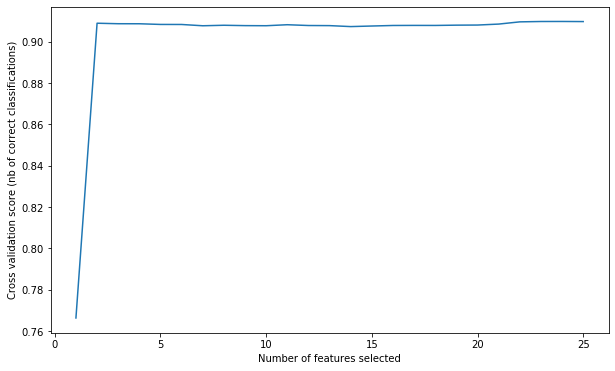

In [62]:

# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct classifications
rfecv = RFECV(estimator=LogisticRegression(solver='lbfgs', max_iter=3000), step=1, cv=10, scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(X.columns[rfecv.support_]))

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Model accuracy jumps when using 3 features and then hoves in the 90% accuracy range with additional features added. What are the three features that are meaningful here? Try the RFE again but select three. 

In [65]:
## Let'a figure out which features are most important to the model using recursive feature elimination. 


cols =['Gender', 'Age', 'Scholarship', 'Hypertension',
       'Diabetes', 'Alcoholism', 'Handicap', 'SMS_Reminders', 'Friday', 'Monday', 'Saturday', 'Thursday',
       'Tuesday', 'Wednesday', 'WaitFromScheduledDate', 'ScheduledDayOfWeekNumeric',
       'ScheduledHourOfDay', 'ApptFreq', 'AbsenceFreq','A','B','C','D','E','F']
X = df[cols]
y = df['Attendance']
# Build a logreg and compute the feature importances
model = LogisticRegression(solver='lbfgs', max_iter = 3000)
# create the RFE model and select 3 attributes
rfe = RFE(model,3)
rfe = rfe.fit(X, y)
# summarize the selection of the attributes
print('Selected features: %s' % list(X.columns[rfe.support_]))


Selected features: ['Handicap', 'ApptFreq', 'AbsenceFreq']


So this simple logistic regression is drawing from Appointment Frequency, Absence Frequency, and handicap conditions. Some questions to consider:

- How does this model interpret handicap? Even when we look at the top 20 variables that correlate with attendance, the handicap variable is not one of them. We want to investigate this further.
- How reliable is a model that is is dominated by three variables, where two of them have been engineered by the dataset? 
- There's a positive correlation between the appointment frequency and attendance. Does this model bias make wrong assumptions about new patients not attending their appointments? 

### PCA Analysis

"Principal Component Analysis (PCA) is an unsupervised, non-parametric statistical technique primarily used for dimensionality reduction in machine learning.

High dimensionality means that the dataset has a large number of features. The primary problem associated with high-dimensionality in the machine learning field is model overfitting, which reduces the ability to generalize beyond the examples in the training set. Richard Bellman described this phenomenon in 1961 as the Curse of Dimensionality where “Many algorithms that work fine in low dimensions become intractable when the input is high-dimensional. "

https://medium.com/apprentice-journal/pca-application-in-machine-learning-4827c07a61db

### Feature Scaling



In [67]:
X_tr=pd.DataFrame(data=X_tr,columns=X_train.columns)

In [68]:
scaler = StandardScaler()

X_tr[X_train.columns] = scaler.fit_transform(X_tr[X_train.columns])

X_tr.describe()

,Gender,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_Reminders,Friday,Monday,...,WaitFromScheduledDate,ScheduledHourOfDay,ApptFreq,AbsenceFreq,A,B,C,D,E,F
count,4.616000e+04,4.616000e+04,4.616000e+04,4.616000e+04,4.616000e+04,4.616000e+04,4.616000e+04,4.616000e+04,4.616000e+04,4.616000e+04,...,4.616000e+04,4.616000e+04,4.616000e+04,4.616000e+04,4.616000e+04,4.616000e+04,4.616000e+04,4.616000e+04,4.616000e+04,4.616000e+04
mean,-6.803724e-17,6.965351e-17,-4.787236e-17,1.314566e-16,3.147877e-17,-3.471131e-17,-3.278718e-17,-6.172609e-17,8.127525e-17,-2.339742e-17,...,1.693234e-18,7.696520e-17,8.050560e-17,1.308408e-17,-3.078608e-17,-1.416160e-17,4.864201e-17,1.570090e-17,-7.142371e-17,-4.186907e-17
std,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,...,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00
min,-7.056023e-01,-1.681109e+00,-3.205870e-01,-5.146845e-01,-2.853694e-01,-1.597720e-01,-1.273543e-01,-1.261840e+00,-4.583531e-01,-5.014889e-01,...,-9.237861e-01,-1.682591e+00,-6.157537e-01,-6.582602e-01,-4.945780e-01,-4.822963e-01,-8.056684e-01,-1.986851e-01,-3.558800e-01,-2.759369e-01
25%,-7.056023e-01,-8.094369e-01,-3.205870e-01,-5.146845e-01,-2.853694e-01,-1.597720e-01,-1.273543e-01,-1.261840e+00,-4.583531e-01,-5.014889e-01,...,-7.340737e-01,-7.725956e-01,-6.157537e-01,-6.582602e-01,-4.945780e-01,-4.822963e-01,-8.056684e-01,-1.986851e-01,-3.558800e-01,-2.759369e-01
50%,-7.056023e-01,1.865144e-02,-3.205870e-01,-5.146845e-01,-2.853694e-01,-1.597720e-01,-1.273543e-01,7.924938e-01,-4.583531e-01,-5.014889e-01,...,-3.546490e-01,-1.659322e-01,-1.012230e-01,-6.582602e-01,-4.945780e-01,-4.822963e-01,-8.056684e-01,-1.986851e-01,-3.558800e-01,-2.759369e-01
75%,1.417229e+00,8.031562e-01,-3.205870e-01,-5.146845e-01,-2.853694e-01,-1.597720e-01,-1.273543e-01,7.924938e-01,-4.583531e-01,-5.014889e-01,...,4.674380e-01,7.440630e-01,4.133077e-01,4.534917e-01,-4.945780e-01,-4.822963e-01,1.241206e+00,-1.986851e-01,-3.558800e-01,-2.759369e-01
max,1.417229e+00,2.590084e+00,3.119278e+00,1.942938e+00,3.504231e+00,6.258919e+00,2.623442e+01,7.924938e-01,2.181724e+00,1.994062e+00,...,6.917658e+00,2.867385e+00,1.173298e+01,8.235755e+00,2.021926e+00,2.073414e+00,1.241206e+00,5.033091e+00,2.809936e+00,3.624017e+00


In [69]:
X_te = scaler.transform(X_test)

In [70]:
X_te = pd.DataFrame(data = X_test,columns= X_train.columns)

# PCA Analysis


In [71]:
pca = PCA(svd_solver='randomized', random_state=42)
#PCA on the train data
pca.fit(X_tr)
pca.components_

colnames = list(X_tr.columns)
pcs_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'Feature':colnames})

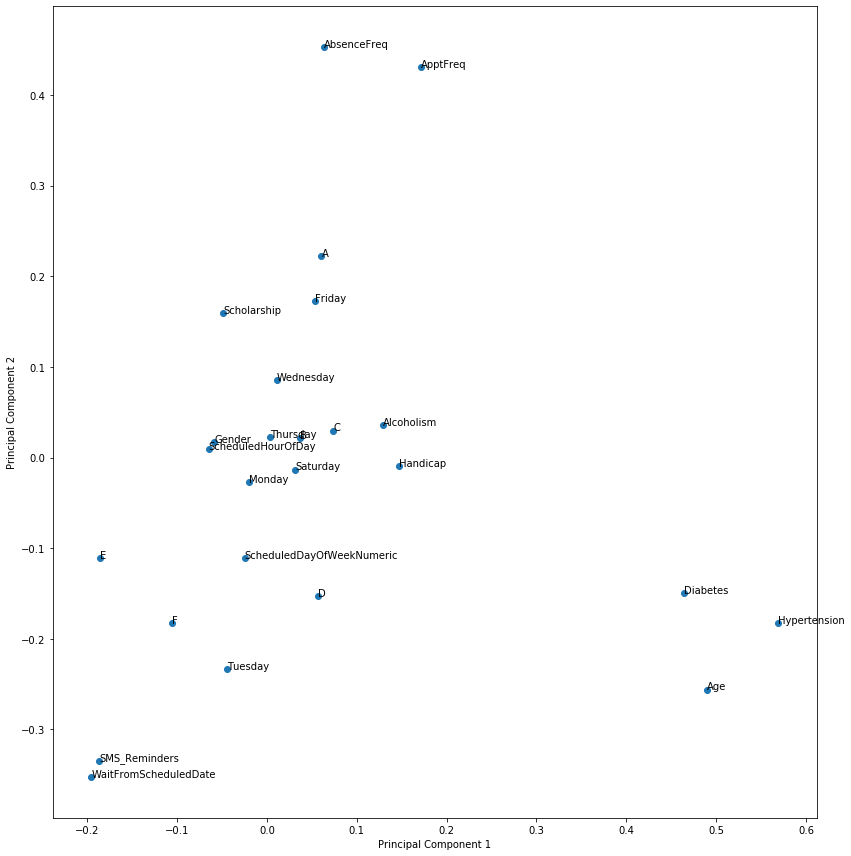

In [75]:
%matplotlib inline
fig = plt.figure(figsize = (12,12))
plt.scatter(pcs_df.PC1, pcs_df.PC2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i, txt in enumerate(pcs_df.Feature):
    plt.annotate(txt, (pcs_df.PC1[i],pcs_df.PC2[i]))
plt.tight_layout()
plt.show()

Interesting... we can see which variables are clustered near each other and might be experiencing some degreee of a  collinearity issue.

Similiar variables:


[Absencefreq, ApptFreq] <br>
[Age, Diabetes, Hypertension]<br>
[WaitFromScheduledDate, SMSReminders]<br>
A bunch of variables all clustered in the middle of this graph may be causing issues

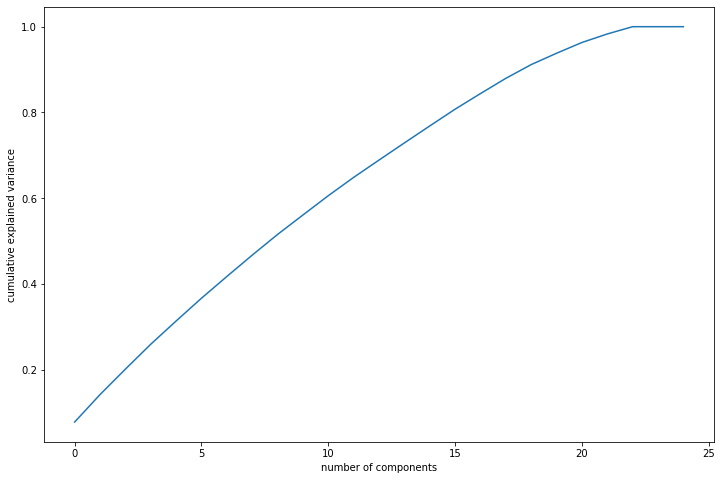

In [77]:
pca.explained_variance_ratio_

#Making the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

Select somewhere around 20 features to explain the variance... After that, the the graph of explained variance approaches an asymptote

In [78]:
#Using incremental PCA for efficiency - saves a lot of time on larger datasets

pca_final = IncrementalPCA(n_components=20)

In [79]:
df_train_pca = pca_final.fit_transform(X_tr)
#creating correlation matrix for the principal components
corrmat = np.corrcoef(df_train_pca.transpose())

(46160, 20)

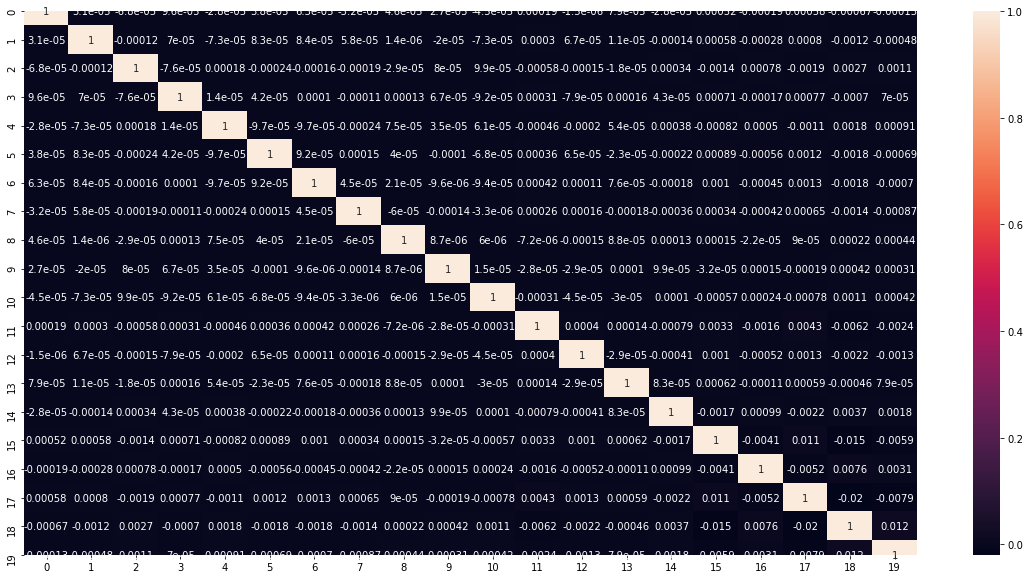

In [81]:
#plotting the correlation matrix
%matplotlib inline
plt.figure(figsize = (20,10))
sns.heatmap(corrmat,annot = True)
plt.show()

In [82]:
# 1s -> 0s in diagonals
corrmat_nodiag = corrmat - np.diagflat(corrmat.diagonal())
print("max corr:",corrmat_nodiag.max(), ", min corr: ", corrmat_nodiag.min(),)
# we see that correlations are indeed very close to 0

max corr: 0.012386397685434104 , min corr:  -0.019668506966184114


Low correlation scores = Confirmed that we've removed multicolinearity issues

In [83]:
#Applying selected components to the test data - 40 components
df_test_pca = pca_final.transform(X_te)

(11540, 20)

# Logistic Regression Post PCA

In [84]:
#Training the model on the train data
learner_pca = LogisticRegression()
model_pca = learner_pca.fit(df_train_pca,y_tr)

/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [85]:
#Making prediction on the train data
pred_probs_train = model_pca.predict_proba(df_train_pca)[:,1]
"{:2.2}".format(metrics.roc_auc_score(y_tr, pred_probs_train))

'0.79'

In [86]:
#Making prediction on the test data
pred_probs_test = model_pca.predict_proba(df_test_pca)[:,1]
"{:2.2}".format(metrics.roc_auc_score(y_test, pred_probs_test))

'0.6'

Predictions on the training data

In [90]:
##Evaluations on the training data
predictions_train = model_pca.predict(df_train_pca)
print(confusion_matrix(y_tr,predictions_train))
print(classification_report(y_tr,predictions_train))

[[ 3114  9810]
 [ 2282 30954]]
              precision    recall  f1-score   support

           0       0.58      0.24      0.34     12924
           1       0.76      0.93      0.84     33236

    accuracy                           0.74     46160
   macro avg       0.67      0.59      0.59     46160
weighted avg       0.71      0.74      0.70     46160



In [91]:
#Evaluations on the test data
predictions_test = model_pca.predict(df_test_pca)
print(confusion_matrix(y_test,predictions_test))
print(classification_report(y_test,predictions_test))

[[ 628 2605]
 [1012 7295]]
              precision    recall  f1-score   support

           0       0.38      0.19      0.26      3233
           1       0.74      0.88      0.80      8307

    accuracy                           0.69     11540
   macro avg       0.56      0.54      0.53     11540
weighted avg       0.64      0.69      0.65     11540



The accuracy on our test data drastically fell after performing feature scaling and PCA to nix multicollinearity issues with our data. This severe dip in performance indicates that there is some overfitting occuring on the original model. We might also be concerned that over the 24 variables introduced to the model, three of them are used to generate >90% accuracy scores.

In [92]:
# Creating a data frame to hold the ground truth 'churn' and the predicted probability for the imbalanced training dataset
pca_y_train_pred_final = pd.DataFrame(list(zip(y_tr.tolist(), pred_probs_train.tolist())),
              columns=['Attendance','Attendance_prob'])

In [93]:
# Creating a data frame to hold the ground truth 'churn' and the predicted probability for the testing dataset
pca_y_test_pred_final = pd.DataFrame(list(zip(y_test.tolist(), pred_probs_test.tolist())),
              columns=['Attendance','Attendance_prob'])

In [94]:
fpr, tpr, thresholds = metrics.roc_curve(pca_y_train_pred_final.Attendance, pca_y_train_pred_final.Attendance_prob, drop_intermediate = False )

In [96]:
# Defining a function to plot the ROC-AUC curve
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0, 1.0])
    plt.ylim([0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

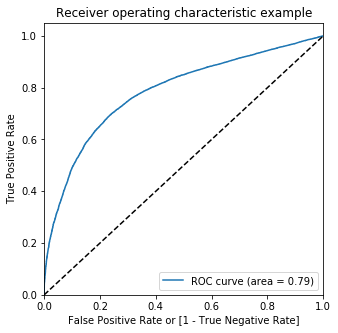

In [97]:
#ROC on training data
draw_roc(pca_y_train_pred_final.Attendance, pca_y_train_pred_final.Attendance_prob)

In [98]:
fpr, tpr, thresholds = metrics.roc_curve( pca_y_test_pred_final.Attendance, pca_y_test_pred_final.Attendance_prob, drop_intermediate = False )

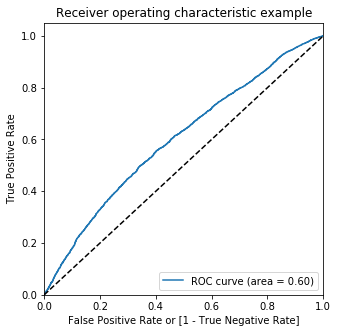

In [99]:
# ROC on test data
draw_roc(pca_y_test_pred_final.Attendance, pca_y_test_pred_final.Attendance_prob)

We attempted to scale all the features and identify relationships between variables that might skew our model. This work in dimensionality reduction ended up signficantly reducing the model accuracy (91% on the test set -> 69% on the test set - which is even worse than predicing everyone will attend each appointment. There's clearly some overfitting issue on the logistic regression that's likely occuring on the appointment freqency and absence frequency variables. 

### Random Forest Model

In [100]:
#Split data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=100)
X_tr = X_train
y_tr = y_train

In [101]:
model_rf = RandomForestClassifier()
model_rf.fit(X_tr, y_tr)

# Make predictions
prediction_test = model_rf.predict(X_test)
print ('Random Forest Accuracy with Default Hyperparameter on the test set',metrics.accuracy_score(y_test, prediction_test))
print('Random Forest AUC with Default Hyperparameter on the test set',metrics.roc_auc_score(y_test, prediction_test))

/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest Accuracy with Default Hyperparameter on the test set 0.8923743500866551
Random Forest AUC with Default Hyperparameter on the test set 0.8779168463715586


In [102]:


# GridSearchCV to find optimal n_estimators


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(2, 20, 5)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="roc_auc", return_train_score=True)
rf.fit(X_tr, y_tr)



/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jordan/miniconda3/lib/python3.7/si

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [103]:
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.077484,0.007803,0.010144,0.001027,2,{'max_depth': 2},0.915501,0.938200,0.944641,0.947973,...,0.932110,0.014430,4,0.921775,0.939196,0.944143,0.946160,0.918578,0.933970,0.011533
1,0.146442,0.017925,0.012948,0.002906,7,{'max_depth': 7},0.969805,0.960798,0.968150,0.973668,...,0.967576,0.004309,3,0.972535,0.963469,0.968867,0.974056,0.969776,0.969740,0.003648
2,0.211046,0.037066,0.019617,0.007723,12,{'max_depth': 12},0.973358,0.971867,0.973635,0.975557,...,0.973529,0.001184,1,0.987494,0.986432,0.986468,0.986105,0.986362,0.986572,0.000478
3,0.220451,0.038919,0.022846,0.005870,17,{'max_depth': 17},0.967343,0.969349,0.971983,0.973571,...,0.970495,0.002145,2,0.997471,0.997564,0.997071,0.996949,0.997362,0.997283,0.000235


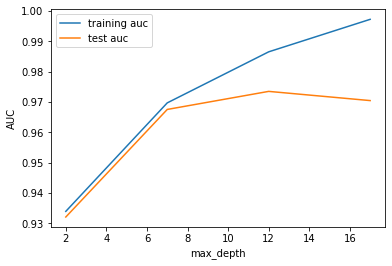

In [104]:


# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training auc")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test auc")
plt.xlabel("max_depth")
plt.ylabel("AUC")
plt.legend()
plt.show()



In [105]:
#GridSearchCV to find optimal n_estimators


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(50, 400, 50)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="roc_auc", return_train_score=True)
rf.fit(X_tr, y_tr)

/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jordan/miniconda3/lib/python3.7/si

/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

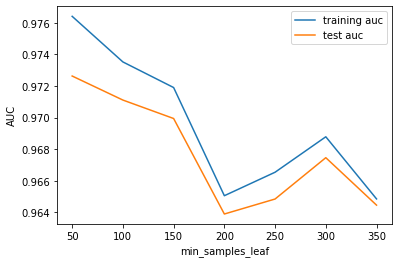

In [106]:
# plotting auc's with min_samples_leaf
scores = rf.cv_results_
pd.DataFrame(scores).head()
plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training auc")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test auc")
plt.xlabel("min_samples_leaf")
plt.ylabel("AUC")
plt.legend()
plt.show()

In [107]:
# GridSearchCV to find optimal n_estimators



# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(300, 800, 100)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="roc_auc", return_train_score=True)
rf.fit(X_tr, y_tr)

/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jordan/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jordan/miniconda3/lib/python3.7/si

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

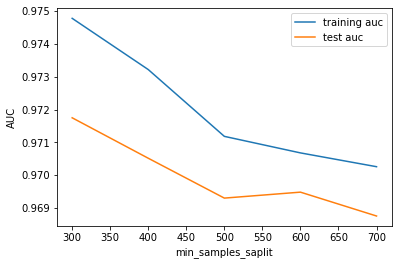

In [108]:
# scores of GridSearch CV
scores = rf.cv_results_

# plotting accuracies with min_samples_split
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training auc")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test auc")
plt.xlabel("min_samples_saplit")
plt.ylabel("AUC")
plt.legend()
plt.show()

In [109]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [4,8],
    'min_samples_leaf': range(100, 400, 200),
    'min_samples_split': range(300, 700, 200),
    'n_estimators': [100,200], 
    'max_features': [5, 10]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1,verbose = 1, scoring = 'roc_auc')

In [110]:
grid_search.fit(X_tr, y_tr)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  1.6min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [111]:
# printing the optimal accuracy score and hyperparameters
print('We can get an auc of',grid_search.best_score_,'using',grid_search.best_params_)

We can get an auc of 0.9767667882618171 using {'max_depth': 8, 'max_features': 10, 'min_samples_leaf': 100, 'min_samples_split': 300, 'n_estimators': 200}


In [112]:
# Fitting the RandomForestClassifier using the best parameters obtained by Grid Search CV on the train set
m1= RandomForestClassifier(n_estimators=100,max_depth=8, min_samples_leaf=100,min_samples_split=300, max_features=10, n_jobs=-1)
m1.fit(X_tr,y_tr)
m1.score(X_test,y_test)

0.9072790294627383

In [113]:
#Predicting probabilities on the balanced training data set, imbalanced training data set and tst set
y_trprob = m1.predict_proba(X_tr)[:,1]
y_trainprob = m1.predict_proba(X_train)[:,1]
y_testprob = m1.predict_proba(X_test)[:,1]

In [114]:
# Creating a data frame to hold the ground truth 'Attendance' and the predicted probability for the balanced training dataset
y_tr_pred_final = pd.DataFrame(list(zip(y_tr.tolist(), y_trprob.tolist())),
              columns=['Attendance','Attendance_prob'])
# Creating a data frame to hold the ground truth 'Attendance' and the predicted probability for the imbalanced training dataset
y_train_pred_final = pd.DataFrame(list(zip(y_train.tolist(), y_trainprob.tolist())),
              columns=['Attendance','Attendance_prob'])


In [116]:
# Creating a data frame to hold the ground truth 'Attendance' and the predicted probability for the testing dataset
y_test_pred_final = pd.DataFrame(list(zip(y_test.tolist(), y_testprob.tolist())),
              columns=['Attendance','Attendance_prob'])

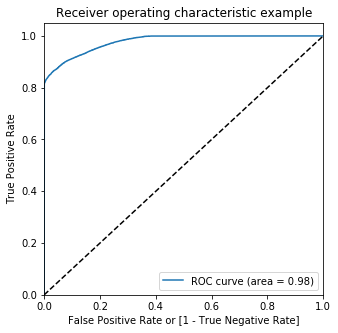

In [117]:
fpr, tpr, thresholds = metrics.roc_curve( y_tr_pred_final.Attendance, y_tr_pred_final.Attendance_prob, drop_intermediate = False )
#Fitting on the training dataset
draw_roc(y_tr_pred_final.Attendance, y_tr_pred_final.Attendance_prob)

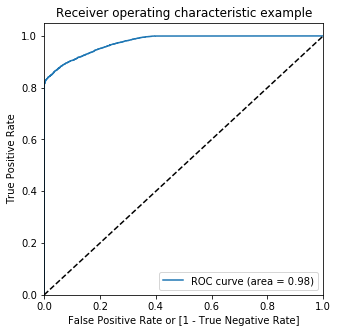

In [119]:
##Fitting on the test set
fpr, tpr, thresholds = metrics.roc_curve(y_test_pred_final.Attendance, y_test_pred_final.Attendance_prob, drop_intermediate = False )
draw_roc(y_test_pred_final.Attendance, y_test_pred_final.Attendance_prob)

In [120]:
# Let's create columns with different probability cutoffs on the test set
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_test_pred_final[i]= y_test_pred_final.Attendance_prob.map(lambda x: 1 if x > i else 0)
y_test_pred_final.head()

,Attendance,Attendance_prob,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.194576,1,1,0,0,0,0,0,0,0,0
1,1,0.993891,1,1,1,1,1,1,1,1,1,1
2,1,1.000000,1,1,1,1,1,1,1,1,1,1
3,1,0.687125,1,1,1,1,1,1,1,0,0,0
4,0,0.562958,1,1,1,1,1,1,0,0,0,0


In [121]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci', 'preci'])


# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_test_pred_final.Attendance, y_test_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    preci = cm1[1,1]/(cm1[1,1]+cm1[0,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci, preci]
print(cutoff_df)



     prob  accuracy     sensi     speci     preci
0.0   0.0  0.719844  1.000000  0.000000  0.719844
0.1   0.1  0.851213  1.000000  0.468914  0.828711
0.2   0.2  0.873397  1.000000  0.548098  0.850430
0.3   0.3  0.890815  0.999157  0.612434  0.868837
0.4   0.4  0.903986  0.981582  0.704609  0.895159
0.5   0.5  0.907279  0.936198  0.832972  0.935073
0.6   0.6  0.892548  0.868063  0.955459  0.980421
0.7   0.7  0.870711  0.821717  0.996598  0.998391
0.8   0.8  0.863085  0.809799  1.000000  1.000000
0.9   0.9  0.863085  0.809799  1.000000  1.000000


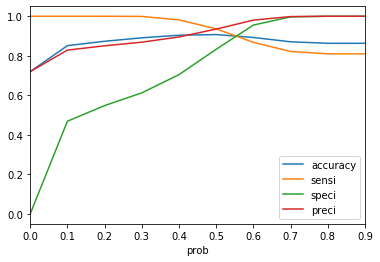

In [122]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci', 'preci'])
plt.show()

In [125]:

metrics.confusion_matrix(y_test_pred_final.Attendance, y_test_pred_final[0.5])
print(classification_report(y_test_pred_final.Attendance, y_test_pred_final[0.5]))

              precision    recall  f1-score   support

           0       0.84      0.83      0.83      3233
           1       0.94      0.94      0.94      8307

    accuracy                           0.91     11540
   macro avg       0.89      0.88      0.88     11540
weighted avg       0.91      0.91      0.91     11540



Hitting 91% accuracy!


But 84% precision rate for patients that don't attend their appointment. This means that whenver the algorithm predicts no-show, 84% of the time it is correct. However 16% of the time, those are false negatives. 



It's better to err on the side of caution and assume more patients will come to their appointment than to assume they will miss. So we can tolerate reduction to the recall rate. Precision is what we'd really like to improve. When the algorithm predicts negative, we want to hold a high degree of confidence that the patient will not show up before taking alternative course of action. Can we improve precision?

In [131]:
print("Setting the threshold at 0.4")
print(metrics.confusion_matrix(y_test_pred_final.Attendance, y_test_pred_final[0.4]))
print(classification_report(y_test_pred_final.Attendance, y_test_pred_final[0.4]))

print("Setting the threshold at 0.3")
print(metrics.confusion_matrix(y_test_pred_final.Attendance, y_test_pred_final[0.3]))
print(classification_report(y_test_pred_final.Attendance, y_test_pred_final[0.3]))

Setting the threshold at 0.4
[[2278  955]
 [ 153 8154]]
              precision    recall  f1-score   support

           0       0.94      0.70      0.80      3233
           1       0.90      0.98      0.94      8307

    accuracy                           0.90     11540
   macro avg       0.92      0.84      0.87     11540
weighted avg       0.91      0.90      0.90     11540

Setting the threshold at 0.3
[[1980 1253]
 [   7 8300]]
              precision    recall  f1-score   support

           0       1.00      0.61      0.76      3233
           1       0.87      1.00      0.93      8307

    accuracy                           0.89     11540
   macro avg       0.93      0.81      0.84     11540
weighted avg       0.90      0.89      0.88     11540



Great! We're scoring around 90% accuracy- but we can set our precision between 94 and nearly 100%. Of the roughly 11500 instances in the test set, we're accurately predicting nearly 2000 patient no shows, though missing about 1000 people who missed their appointment but the algorithm predicted their attendance. 

Is there anything interesting we can dig up on the population that gets cut here?

What do we observe about the patients who are consistently predicted incorrectly by the algorithm?

In [133]:
feature_importances = pd.DataFrame(m1.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.head(10)



,importance
AbsenceFreq,0.828754
ApptFreq,0.146070
WaitFromScheduledDate,0.011430
Age,0.008344
ScheduledHourOfDay,0.001686
SMS_Reminders,0.000983
Hypertension,0.000498
ScheduledDayOfWeekNumeric,0.000418
Scholarship,0.000327
A,0.000239


What's going on in region A? It's influencing the model somehow. Spot for future study. 

### Gradient Boosting Model

In [134]:
# Calculate mae and rmse
def evaluate_predictions(predictions, true):
    mae = np.mean(abs(predictions - true))
    rmse = np.sqrt(np.mean((predictions - true) ** 2))
    
    return mae, rmse



In [135]:
# Putting feature variable to X
X = df.drop(['Attendance', 'PatientId', 'AppointmentID', 'ScheduledDay', 'AppointmentDay', 'AppointmentDayOfWeek','ScheduledDayOfWeek', 'Neighborhood','NeighborhoodGrouping'] ,axis=1)
# Putting response variable to y
y = df['Attendance']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=100)

In [136]:
# Load data
X_trainGB = X_train.to_numpy()
X_testGB = X_test.to_numpy()

In [137]:
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_trainGB, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)

MSE: 0.0528


Text(0, 0.5, 'Deviance')

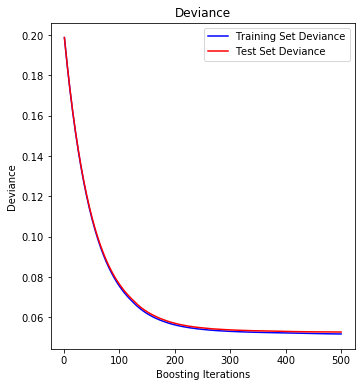

In [138]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_testGB)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

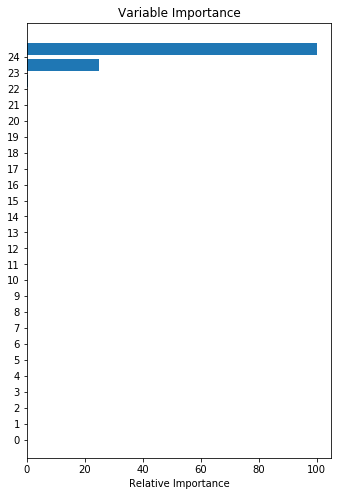

In [139]:
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
plt.figure(figsize=(12,8))
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(np.arange(0, 25, step=1))


#plt.yticks(pos, df.get_feature_names([sorted_idx]))
#need to look for a different package: get_feature_names no longer works
plt.xlabel('Relative Importance')
plt.title('Variable Importance')

plt.show()


In [140]:
selection=[]
for i in y_pred:
    if i >= 0.4:
        selection.append(1)
    else:
        selection.append(0)

selectionfortesting = np.asarray(selection)

In [141]:
print(confusion_matrix(y_test, selectionfortesting))
print(classification_report(y_test, selectionfortesting ))

[[2291  942]
 [ 107 8200]]
              precision    recall  f1-score   support

           0       0.96      0.71      0.81      3233
           1       0.90      0.99      0.94      8307

    accuracy                           0.91     11540
   macro avg       0.93      0.85      0.88     11540
weighted avg       0.91      0.91      0.90     11540



Great overall scores on the test data for this algorithm as well, but is heavily dominated by two variables - presumably appointment frequency and absence frequency. 

Will run the algorithms again with appointment freqency and absence frequency removed to see their affect on our accuracy scores. 

## Findings and Suggestions for the Practice

- No shows are more apparent in individuals 20-40 years old. Older patients are much more likely to attend their scheduled appointments. Communicate the value of attending their appointments for preventative care to these younger populations. 
- Texts do not seem to make a signficant influence on patient attendance when the appointment is scheduled for a few days in the future. May be more meaningful to focus on texting all individuals who have appointments far into the future. 
- Patients are more often missing friday and saturday appointments than any other days of the week. Look into why this is the case. IS it possible to schedule more appointments on Wednesday or Thursday when the facility sees the highest rate of attendance?
- Can accurately predict 91% of the instances in the test set with logistic regression, random forest, and gradient boosting {Attend appointment or No-show}. May improve model accuracy to use an ensemble of models. Run more tests on more robust data.
- These models are primarily driven from the features, appointment frequency and absence frequency. After performing PCA on the data and running logistic regression, these models could be instances of overfitting on these two similar variables. Recommend further study on these models before any clinical utility. 
- The northern regions are attending their appointments more frequently than the southern region. Regions A, B, and C (South) report higher frequency of patients with alcoholism, diabetes, and those on scholarship than regions D, E, and F (North). Focus clinical efforts on drawing more patients from these region for preventative measures and earier interventions. 


## Discussion Questions

- What are some potential sources of bias in this algorithm? What might these biases mean for practice if this sort of algorithm were to roll out?
    - Ex: Roughly 9% of patients in the data are on scholarship. According to wikipedia, the scholarship rate across the state was 26% in 2017. So this may be a wealthier population we're examining in the data compared to the state. According to an article published in the Atlantic, wealthier people often see private doctors instead of public healthcare - unless their private doctors prescribe costly procedures, which are often covered in Brazil's universal healthcare.
    - How does the first logistic regression model interpret handicap? Even when we look at the top 20 variables that correlate with attendance, the handicap variable is not one of them. Yet the model seems to draw from this feature as one of the primary three that contribute to 91% accuracy.
    - All of the models we built placed heavy important on appointment frequency and absence frequency. Will this negatively impact new patients?
- What is the best manner to apply the results of this sort of algorithm, if at all?
    - What should the algorithm return? 
- What are the important variables that an algorithm should have access to? Where should access be limited?
    - Are there any accessible variables that pose risk of building a model to predict those patient information (ex: handicap, alcoholism, diabetes)? What data should the algorithm tap in the facility?
- What are some common evaluation metrics to understand how well a classifier performs?
    - What are some best practices for disclosing how models were trained and tested?
- Would this be an AI task that would be important to monitor in a registry? If so, what data would you want to collect about this task?
- What do we observe about the patients who are consistently predicted incorrectly by the algorithm?
- How could I get started on some inhouse ML projects?